### Utilisation de Google Colab

Si vous utilisez Google Colab, suivez les instructions ci-dessous.

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. Installer ensuite deeplib avec la commande suivante:

In [1]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

  Cloning https://github.com/ulaval-damas/glo4030-labs.git to /tmp/pip-req-build-li5mm8kx
  Running command git clone --filter=blob:none --quiet https://github.com/ulaval-damas/glo4030-labs.git /tmp/pip-req-build-li5mm8kx
  Resolved https://github.com/ulaval-damas/glo4030-labs.git to commit c5c2d5abb7ddc59a63798ccb02b6109aa007c065
  Preparing metadata (setup.py) ... done



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


# Laboratoire 8: Transformers

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from typing import Callable, Optional

import numpy as np

import torch
import torch.random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.pyplot as plt

import deeplib.training as dtrain
import deeplib.datasets as ddatasets

## Partie 1: Transformers
- Transformer ont révolutionnés le NLP (Vaswani, 2017), citer quelques exemples en NLP (BERT, GPT, etc.)
- Maintenant ont les retrouve partout en deep learning, citer quelques exemples en CV, Audio (ViT, Swin, DETR, etc.)
- Outil très polivalent en deep learning
- Pretrain sur d'immenses jeux de données
- Foundation models

- Inpiré par https://d2l.ai/chapter_attention-mechanisms-and-transformers/index.html et https://medium.com/the-dl/transformers-from-scratch-in-pytorch-8777e346ca51


## Attention
- Attention est au coeur des transformers
- Focus sur certaines parties de l'entrée, somme pondérée

- Similaire aux requêtes sur une base de données $D = \{(k_1, v_1), \ldots (k_m, v_m)\}$. $k_i$ = clé, $v_i$ valeur associée à la clé
- Attention fait une requête q, et fait la somme pondérée des réponses, $\alpha$ = fonction qui dit comment la k correspond à q (la requete) (fonction de similarité)

$$Attention(q, D) = \sum_{i=1}^{m}{\alpha(q, k_i)}$$

- Souvent normalize avec softmax

$$\alpha(q, k_i) = \frac{\exp \alpha(q, k_i)}{\sum_j\exp\alpha(q, k_j)} = softmax_{i}(...)$$

Figure Vaswani du scaled dot-product attention, où alpha = dot product entre les k et les q

$$\alpha(q, k_i) = q^Tk_i/\sqrt(d) = q \cdot k_i / \sqrt(d)$$, d = num dim



### Query simple

Visualiser l'attention


In [3]:
q = F.normalize(torch.tensor([[3.0, 3.0]]), dim=1)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [2, -3], [0, 2]]), dim=1)
dimension = float(k.shape[1])

# TODO
alpha = F.softmax(q @ k.T / np.sqrt(dimension), dim=1)
output = alpha @ v

print(output)
# Validate that sums to 1
print(alpha)
print(alpha.sum())


print(f'Query = {q}')
for i in range(k.shape[0]):
    print(f'Keys {i} = {k[i]}, alpha={alpha[0][i]}')

tensor([[0.1089, 0.3322]])
tensor([[0.3939, 0.1770, 0.3225, 0.1067]])
tensor(1.0000)
Query = tensor([[0.7071, 0.7071]])
Keys 0 = tensor([0.8000, 0.6000]), alpha=0.3938761055469513
Keys 1 = tensor([-0.8000,  0.6000]), alpha=0.1769799292087555
Keys 2 = tensor([0., 1.]), alpha=0.3224784731864929
Keys 3 = tensor([-0.2425, -0.9701]), alpha=0.10666542500257492


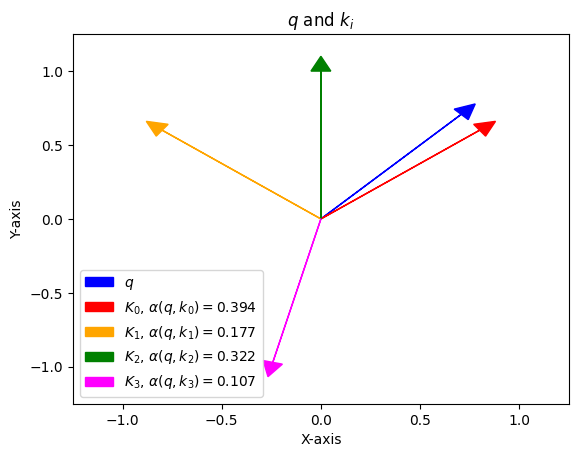

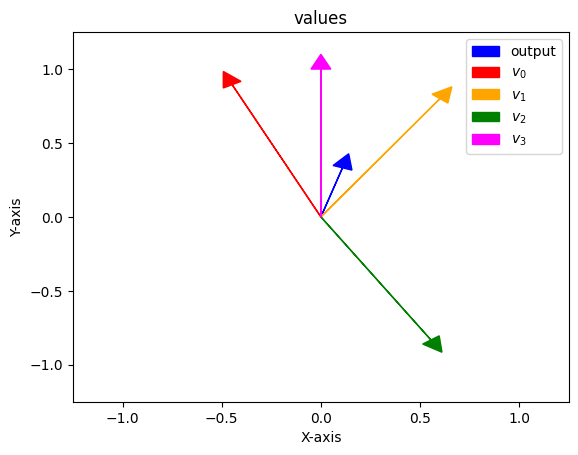

In [4]:
# TODO make a function
fig, ax = plt.subplots()
ax.arrow(0, 0, q[0][0], q[0][1], head_width=0.1, head_length=0.1, fc='b', ec='b', label='$q$')

colors = ['red', 'orange', 'green', 'magenta']
for i, k_i in enumerate(k):
    ax.arrow(0, 0, k_i[0], k_i[1], head_width=0.1, head_length=0.1, label=f'$K_{i}$, $\\alpha(q, k_{i}) = {alpha[0][i]:.3f}$', fc=colors[i], ec=colors[i])

ax.set_xlim(-1.25, 1.25)
ax.set_ylim(-1.25, 1.25)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('$q$ and $k_i$')
ax.legend()

# display the plot
plt.show()

fig, ax = plt.subplots()

ax.arrow(0, 0, output[0][0], output[0][1], head_width=0.1, head_length=0.1, fc='b', ec='b', label='output')

for i, v_i in enumerate(v):
    ax.arrow(0, 0, v_i[0], v_i[1], head_width=0.1, head_length=0.1, label=f'$v_{i}$', fc=colors[i], ec=colors[i])

ax.set_xlim(-1.25, 1.25)
ax.set_ylim(-1.25, 1.25)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('values')
ax.legend()

# display the plot
plt.show()

#### Questions
- alpha selon direction des queries

### Plusieurs queries
Un query = pas assez, formulation en matrices

Q, K, V

Attention(Q, K, V) = softmax(QK.T/sqrt(d))V

Exemple row par row (voir presentation 3DETR)

Equivalent de comparer toutes les queries à toutes les clés (O(n2))

In [5]:
q = F.normalize(torch.tensor([[3.0, 3.0], [-1, 3.2], [0.2, -0.4], [0, -1]]), dim=1)
# q = q[[1, 0, 2, 3]]
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [2, -3], [0, 2]]), dim=1)
# k = k[[1, 0, 2, 3]]
# v = v[[1, 0, 2, 3]]
dimension = float(k.shape[1])

alpha = F.softmax(q @ k.T / np.sqrt(dimension), dim=1)
output = alpha @ v

# TODO show arrows
# print(q)
# print(k)
# print(v)
# print(alpha)
# print(alpha.sum(dim=-1))
print(output)

tensor([[0.1089, 0.3322],
        [0.2860, 0.2639],
        [0.0600, 0.6791],
        [0.0986, 0.7087]])


#### Questions
- Taille de alpha, comment croît si m keys et m queries? Problématique? Temps de calcul? Mémoire?
- Ordre des keys, et values? Ordre alpha et output. Est-ce problématique si l'ordre est important pour le problème (mots dans une phrase)?
- Que se passe-t'il si on change l'ordre des queries? Ordre alpha et output

### Trick pour self-attention
Fusion en une seule couche lineaire

### Batched attention

In [6]:
# TODO
def scaled_dot_product_attention(query, key, value, mask=None):
    temp = query.bmm(key.transpose(-2, -1))  # or query @ key.transpose(1, 2)
    if mask is not None:
        temp[:, mask.logical_not()] = -torch.inf
    scale = query.size(-1) ** 0.5
    softmax = F.softmax(temp / scale, dim=-1)
    return softmax.bmm(value)

q_batch, k_batch, v_batch = q.unsqueeze(0), k.unsqueeze(0), v.unsqueeze(0)
mask = torch.tensor([[1, 1, 1, 1], [1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 0, 0]], dtype=torch.bool)
output = scaled_dot_product_attention(q_batch, k_batch, v_batch, mask)
print(output)

tensor([[[ 0.1089,  0.3322],
         [-0.4472,  0.8944],
         [-0.0533,  0.8589],
         [ 0.0764,  0.8472]]])


### AttentionHead

- Faire module PyTorch qui implemente l'attention
- 3 matrices de projection, q_proj, k_proj, v_proj


In [7]:
# TODO
class AttentionHead(nn.Module):
    def __init__(self, dim_in: int, dim_embed: int):
        super().__init__()
        self.q_proj = nn.Linear(dim_in, dim_embed, bias=False)
        self.k_proj = nn.Linear(dim_in, dim_embed, bias=False)
        self.v_proj = nn.Linear(dim_in, dim_embed, bias=False)
        
    def forward(self, q, k, v, mask=None):
        # TODO dropout
        return scaled_dot_product_attention(self.q_proj(q), self.k_proj(k), self.v_proj(v), mask)

head = AttentionHead(10, 100)
x = torch.randn((1, 10, 10))
print(head(x, x, x).shape)

torch.Size([1, 10, 100])


### MultiHeadAttention
- Multiple attention head
- concat + projection

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_in: int, dim_embed: int):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(dim_in, dim_embed) for _ in range(num_heads)])
        self.fc = nn.Linear(num_heads * dim_embed, dim_in)
        
    def forward(self, q, k, v, mask=None):
        out_head = []
        for h in self.heads:
            out_head.append(h(q, k, v, mask))
        out_head = torch.cat(out_head, dim=-1)
        return self.fc(out_head)
    
m_head = MultiHeadAttention(3, 100, 1000)
x = torch.randn((1, 5, 100))
print(m_head(x, x, x).shape)

torch.Size([1, 5, 100])


### Positional encoding
- Sine and cos at multiple frequencies

PE_(pos, 2i)   = sin(pos / 10000^(2i/d))
PE_(pos, 2i+1) = cos(pos / 10000^(2i/d))

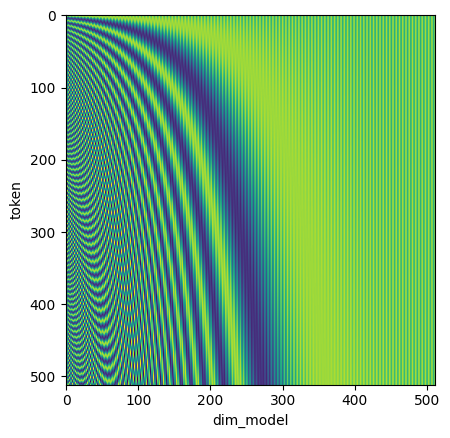

In [9]:
def position_encoding(num_tokens: int, dim_model: int, device: torch.device = torch.device("cpu")):
    pos = torch.arange(num_tokens, dtype=torch.float, device=device).reshape(1, -1, 1)
    dim = torch.arange(dim_model, dtype=torch.float, device=device).reshape(1, 1, -1)
    phase = pos / (10000 ** (dim / dim_model))

    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

pe = position_encoding(512, 512)
plt.imshow(pe.squeeze())
plt.xlabel('dim_model')
plt.ylabel('token')
plt.show()

### TransformerEncoderLayer
- Figure Vaswani


In [10]:

# TODO prenorm
class TransformerEncoderLayer(nn.Module):
    def __init__(self, dim_model: int, num_heads: int, dim_ff: int, dropout: float):
        super().__init__()
        dim_embed = max(dim_model // num_heads, 1)
        
        self.norm_1_q = nn.LayerNorm(dim_model)
        self.norm_1_k = nn.LayerNorm(dim_model)
        self.norm_1_v = nn.LayerNorm(dim_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.attention = MultiHeadAttention(num_heads, dim_model, dim_embed)
        
        self.norm_2 = nn.LayerNorm(dim_model)
        self.dropout_2 = nn.Dropout(dropout)
        # TODO layernorm at the end of sequential
        self.ff = nn.Sequential(nn.Linear(dim_model, dim_ff), nn.GELU(), nn.Linear(dim_ff, dim_model))
        
    def forward(self, q, k, v):

        q, k, v = self.norm_1_q(q), self.norm_1_k(k), self.norm_1_v(v)
        # TODO add dropout on self.attention()
        attention_out = q + self.attention(q, k, v)
        
        return attention_out + self.ff(self.norm_2(attention_out))
        
enc_layer = TransformerEncoderLayer(100, 5, 100, 0.0)
x = torch.randn((1, 5, 100))
print(enc_layer(x, x, x).shape)

torch.Size([1, 5, 100])


### TransformerEncoder
- Multiple layers of transformer enc

In [11]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, dim_ff: int, dropout: float):
        super().__init__()
        self.layers = nn.ModuleList([TransformerEncoderLayer(dim_model, num_heads, dim_ff, dropout) for _ in range(num_layers)])
        
    def forward(self, x):
        num_tokens, dim = x.shape[1], x.shape[2]
        x += position_encoding(num_tokens, dim, x.device)
        for layer in self.layers:
            x = layer(x, x, x)
        return x
    
transformer_enc = TransformerEncoder(6, 100, 2, 100, 0.0)
x = torch.randn((2, 5, 100))
print(transformer_enc(x).shape)

torch.Size([2, 5, 100])


### TransformerDecoder

In [12]:
# TODO prenorm

class TransformerDecoderLayer(nn.Module):
    def __init__(self, dim_model: int, num_heads: int, dim_ff: int, dropout: float):
        super().__init__()
        dim_embed = max(dim_model // num_heads, 1)
        self.norm_1_target = nn.LayerNorm(dim_model)
        self.norm_1_memory = nn.LayerNorm(dim_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.self_attention = MultiHeadAttention(num_heads, dim_model, dim_embed)
        
        self.norm_2 = nn.LayerNorm(dim_model)
        self.dropout_2 = nn.Dropout(dropout)
        self.cross_attention = MultiHeadAttention(num_heads, dim_model, dim_embed)
        
        self.norm_3 = nn.LayerNorm(dim_model)
        self.dropout_3 = nn.Dropout(dropout)
        # TODO layernorm at the end of sequential
        self.ff = nn.Sequential(nn.Linear(dim_model, dim_ff), nn.GELU(), nn.Linear(dim_ff, dim_model))
        
    def forward(self, target, memory):
        # TODO add dropout?
        target, memory = self.norm_1_target(target), self.norm_1_memory(memory)
        target = target + self.self_attention(target, target, target)
        target = target + self.cross_attention(self.norm_2(target), memory, memory)
        return target + self.ff(self.norm_3(target))
    
class TransformerDecoder(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, dim_ff: int, dropout: float):
        super().__init__()
        self.layers = nn.ModuleList([TransformerDecoderLayer(dim_model, num_heads, dim_ff, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(dim_model, dim_model)
        
    def forward(self, target, memory):
        num_tokens, dim = target.shape[1], target.shape[2]
        target += position_encoding(num_tokens, dim, target.device)
        for layer in self.layers:
            target = layer(target, memory)
        # TODO layernorm here
        return self.fc(target)
    
dec = TransformerDecoder(6, 10, 5, 100, 0.0)
target = torch.randn((2, 5, 10))
memory = torch.randn((2, 5, 10))
print(dec(target, memory).shape)

torch.Size([2, 5, 10])


### Transformer

In [13]:
class Transformer(nn.Module):
    def __init__(self, num_enc_layers: int, num_dec_layers: int, dim_model: int, num_head: int, dim_ff: int, dropout: float):
        super().__init__()
        self.encoder = TransformerEncoder(num_enc_layers, dim_model, num_head, dim_ff, dropout)
        self.decoder = TransformerDecoder(num_dec_layers, dim_model, num_head, dim_ff, dropout)
        
    def forward(self, x, target):
        return self.decoder(target, self.encoder(x))

transformer = Transformer(6, 6, 512, 6, 100, 0.1)
x = torch.rand(64, 32, 512)
target = torch.rand(64, 16, 512)
print(transformer(x, target).shape)

torch.Size([64, 16, 512])


## ViT

In [14]:
mnist, mnist_test = ddatasets.load_mnist()
mnist.transform = T.ToTensor()
mnist_test.transform = T.ToTensor()

cifar, cifar_test = ddatasets.load_cifar10()
cifar.transform = T.ToTensor()
cifar_test.transform = T.ToTensor()

Files already downloaded and verified
Files already downloaded and verified


In [15]:
class ViT(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, dim_ff: int, dropout: float):
        super().__init__()
        self.proj = nn.Sequential(nn.Linear(192, dim_model))
        self.cls = nn.Parameter(torch.randn((1, 1, dim_model)))
        self.trans_enc = TransformerEncoder(num_layers, dim_model, num_heads, dim_ff, dropout)
        self.fc = nn.Linear(dim_model, 10)
        
    def forward(self, x):
        batch_size = x.shape[0]
        size = 8
        stride = 1
        
        x = x.unfold(3, size, stride).unfold(2, size, stride) \
            .flatten(-2, -1).flatten(-3, -2) \
            .transpose(-2, -1).flatten(1, 2) \
            .transpose(-2, -1)

        x = self.proj(x)
        cls = torch.cat(batch_size * [self.cls], dim=0)
        x = torch.cat([cls, x], dim=1)
        x = self.trans_enc(x)
        x = self.fc(x[:, 0])
        return x


In [16]:
input_size = 1
num_layers = 2
hidden_size = 20
n_epoch = 20
batch_size = 256
lr = 1e-4

net = ViT(5, 265, 4, 512, 0.1)  # 1024 = 256 * 4
optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=0.)
criterion = nn.CrossEntropyLoss()

history = dtrain.train(net, optimizer, cifar, n_epoch, batch_size, use_gpu=True, criterion=criterion, acc=True)
history.display_loss()
print("Précision en test {:.4f}".format(dtrain.test(net, cifar_test, batch_size, criterion=criterion, acc=True)))

OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 11.76 GiB total capacity; 9.55 GiB already allocated; 273.94 MiB free; 9.87 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Partie X: un peu de théorie
### Attention
Section inspirée par https://d2l.ai/chapter_attention-mechanisms-and-transformers/index.html 
- Attention est au coeur des transformers
- Focus sur certaines parties de l'entrée, somme pondérée

- Similaire aux requêtes sur une base de données $D = \{(k_1, v_1), \ldots (k_m, v_m)\}$. $k_i$ = clé, $v_i$ valeur associée à la clé
- Attention fait une requête q, et fait la somme pondérée des réponses, $\alpha$ = fonction qui dit comment la k correspond à q (la requete) (fonction de similarité)

$$Attention(q, D) = \sum_{i=1}^{m}{\alpha(q, k_i)}$$

- Souvent normalize avec softmax

$$\alpha(q, k_i) = \frac{\exp \alpha(q, k_i)}{\sum_j\exp\alpha(q, k_j)}$$

Permet d'avoir
- $\sum_j\exp\alpha(q, k_j) = 1$
- $exp\alpha(q, k_j) \geq 0$

Donc output = convex combination des valeurs

### Kernel Gaussien et Scaled-Dot Product Attention
alpha(q, k) = exp(-1/2 ||q - k||^2)

Si on inspecte intérieur:
-1/2 ||q - k||^2 = q.T * k_i - 1/2 ||k_i||^2 - 1/2 ||q||^2

||q||^2 depend seulement de la query, pareil pour tout, alors va partir dans la normalisation
||k_i||^2 approx une constante à cause BatchNorm ou LayerNorm
Reste juste q.T * k_i, qui suit N(0, d), d = num dimension, donc
q.T * k_i / sqrt(d)

### Multiple queries
Matric -> compare toutes les q avec toutes les k_i -> O(n^2), donc scale mal avec le nombre d'entré